Audio Classification algorithm test.

Subject A: Male, age 20
Subject Dummy: mannequin with earmuffs to mimic the ear canal.


### Requirements
To run this application, you will need to have Python 3.9.21 installed, along with the following libraries:

- **numpy**
- **matplotlib**
- **scipy**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import wavfile
from scipy.signal import find_peaks

### Code Description
Cell 2: Configuration
- This is the only cell you need to edit.
- All files to be analyzed are defined in the `audio_analysis_jobs` list.
- To add a new file, simply copy an existing job (the block from { to }) and modify its parameters:
    - audio_path: Set the path to your new .wav file.
    - crop_start_s / crop_end_s: Define the time window you want to analyze.
    - bpm_peak_distance: Adjust this to match the expected heart rate. A larger number works better for slower BPMs.

In [10]:
# --- Configuration for Audio-Only Analysis Jobs ---

audio_analysis_jobs = [
    {
        "job_name": "Subject A - Push-up Audio",
        "audio_path": "C:/Users/liyin/OneDrive/Documents/GitHub/objTinDetect/Recordings/Sub_A_PushUps.wav",
        "crop_start_s": 30,
        "crop_end_s": 60,
        "chunk_duration_ms": 50,
        "rms_sd_threshold": 0.05,        # For Sound vs. Noise classification
        "rms_relative_threshold": 0.5,   # For Sound vs. Noise classification
        "bpm_peak_distance": 7,          # Min distance (in chunks) for BPM peaks
    },
    {
        "job_name": "Subject A - Resting Audio",
        "audio_path": "C:/Users/liyin/OneDrive/Documents/GitHub/objTinDetect/Recordings/Sub_A_Rest.wav",
        "crop_start_s": 30,
        "crop_end_s": 60,
        "chunk_duration_ms": 50,
        "rms_sd_threshold": 0.05,
        "rms_relative_threshold": 0.5,
        "bpm_peak_distance": 7,         # A different distance for a slower heart rate
    },
    {
        "job_name": "Subject dummy - right ear Audio",
        "audio_path": "C:/Users/liyin/OneDrive/Documents/GitHub/objTinDetect/Recordings/Sub_Dummy_right_ear.wav",
        "crop_start_s": 30,
        "crop_end_s": 60,
        "chunk_duration_ms": 50,
        "rms_sd_threshold": 0.05,
        "rms_relative_threshold": 0.5,
        "bpm_peak_distance": 7,         # A different distance for a slower heart rate
    },
    {
        "job_name": "Subject dummy - left ear Audio",
        "audio_path": "C:/Users/liyin/OneDrive/Documents/GitHub/objTinDetect/Recordings/Sub_Dummy_left_ear.wav",
        "crop_start_s": 30,
        "crop_end_s": 60,
        "chunk_duration_ms": 50,
        "rms_sd_threshold": 0.05,
        "rms_relative_threshold": 0.5,
        "bpm_peak_distance": 7,         # A different distance for a slower heart rate
    },
    # --- Add more audio analysis jobs here ---
]

print(f"Configuration loaded. Found {len(audio_analysis_jobs)} audio analysis job(s) to process.")

Configuration loaded. Found 4 audio analysis job(s) to process.


### Code Description
Cell 3: Analysis methodology

The script processes each audio file using the following steps:

1. Loading and Pre-processing: The audio file is loaded, converted to mono, and its amplitude is normalized to a standard range of [-1, 1].
2. Cropping: A specific segment of the audio file is selected for analysis based on user-defined start and end times.
3. Chunking and RMS Calculation: The cropped audio is divided into small, consecutive, non-overlapping chunks (e.g., 50 ms). The Root Mean Square (RMS) value, which represents the effective power, is calculated for each chunk.
4. Sound vs. Noise Classification: The script uses the standard deviation of the RMS values across all chunks. A signal with high variance (a large standard deviation) is typically pulsatile or contains distinct events and is classified as "Sound". A signal with low variance is more uniform and is classified as "Noise".
5. BPM Detection:
    - A dynamic threshold is calculated (Mean RMS + 1 Standard Deviation).
    - RMS values below this threshold are set to zero, isolating the significant peaks.
    - The script identifies the peaks in this thresholded signal.
    - The average time interval between these peaks is calculated to estimate the final BPM.
***

### Output
For each audio file defined in the configuration, the script will produce:

- A Multi-Panel Plot:
    - Top Panel: Shows the average absolute waveform, giving a general sense of the signal's structure.
    - Middle Panel: Displays the calculated RMS values for each chunk, used for the "Sound vs. Noise" classification.
    - Bottom Panel: Shows the thresholded RMS signal with the detected peaks clearly marked, along with the final estimated BPM.
- A Console Summary: Printed below the plot, this text report provides the final classification results and the calculated BPM value for easy reference.


PROCESSING JOB 1/4: Subject A - Push-up Audio
Loaded and cropped audio from 30s to 60s.


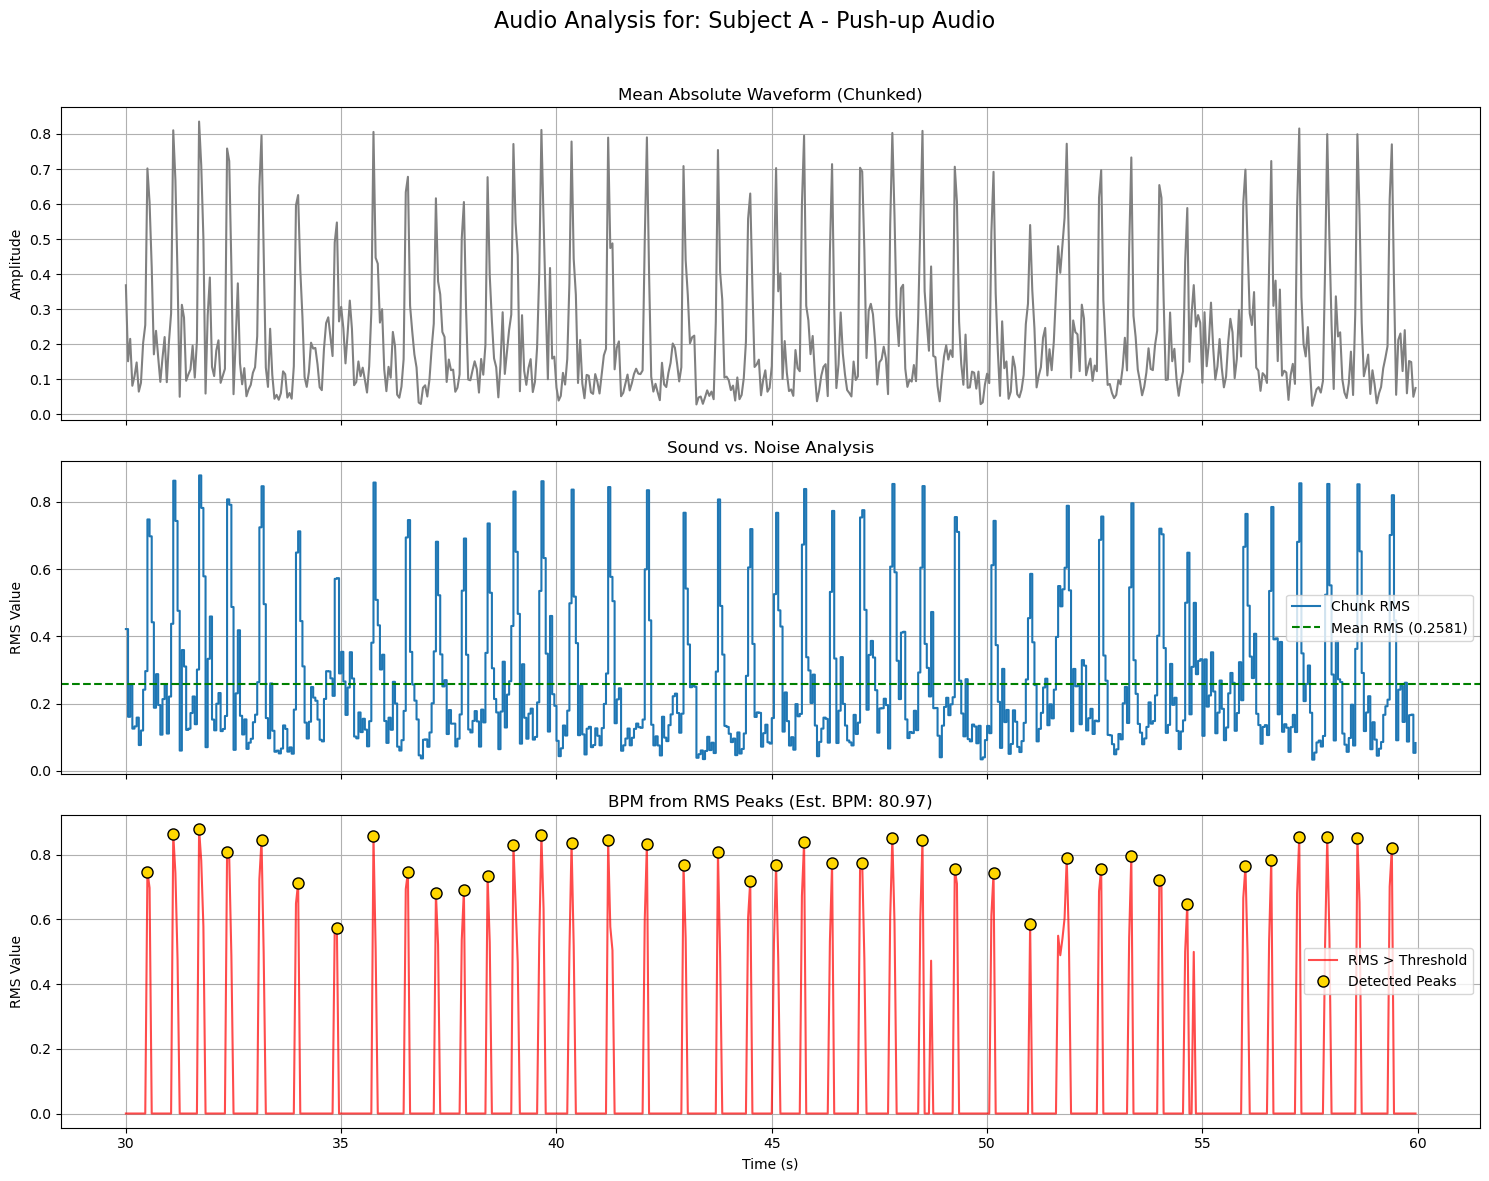


--- Audio Analysis Summary ---
Classification (Fixed SD > 0.05):      Sound
Classification (Relative SD > 0.5): Sound
BPM from RMS Peaks:                  80.97
--------------------------------

PROCESSING JOB 2/4: Subject A - Resting Audio
Loaded and cropped audio from 30s to 60s.


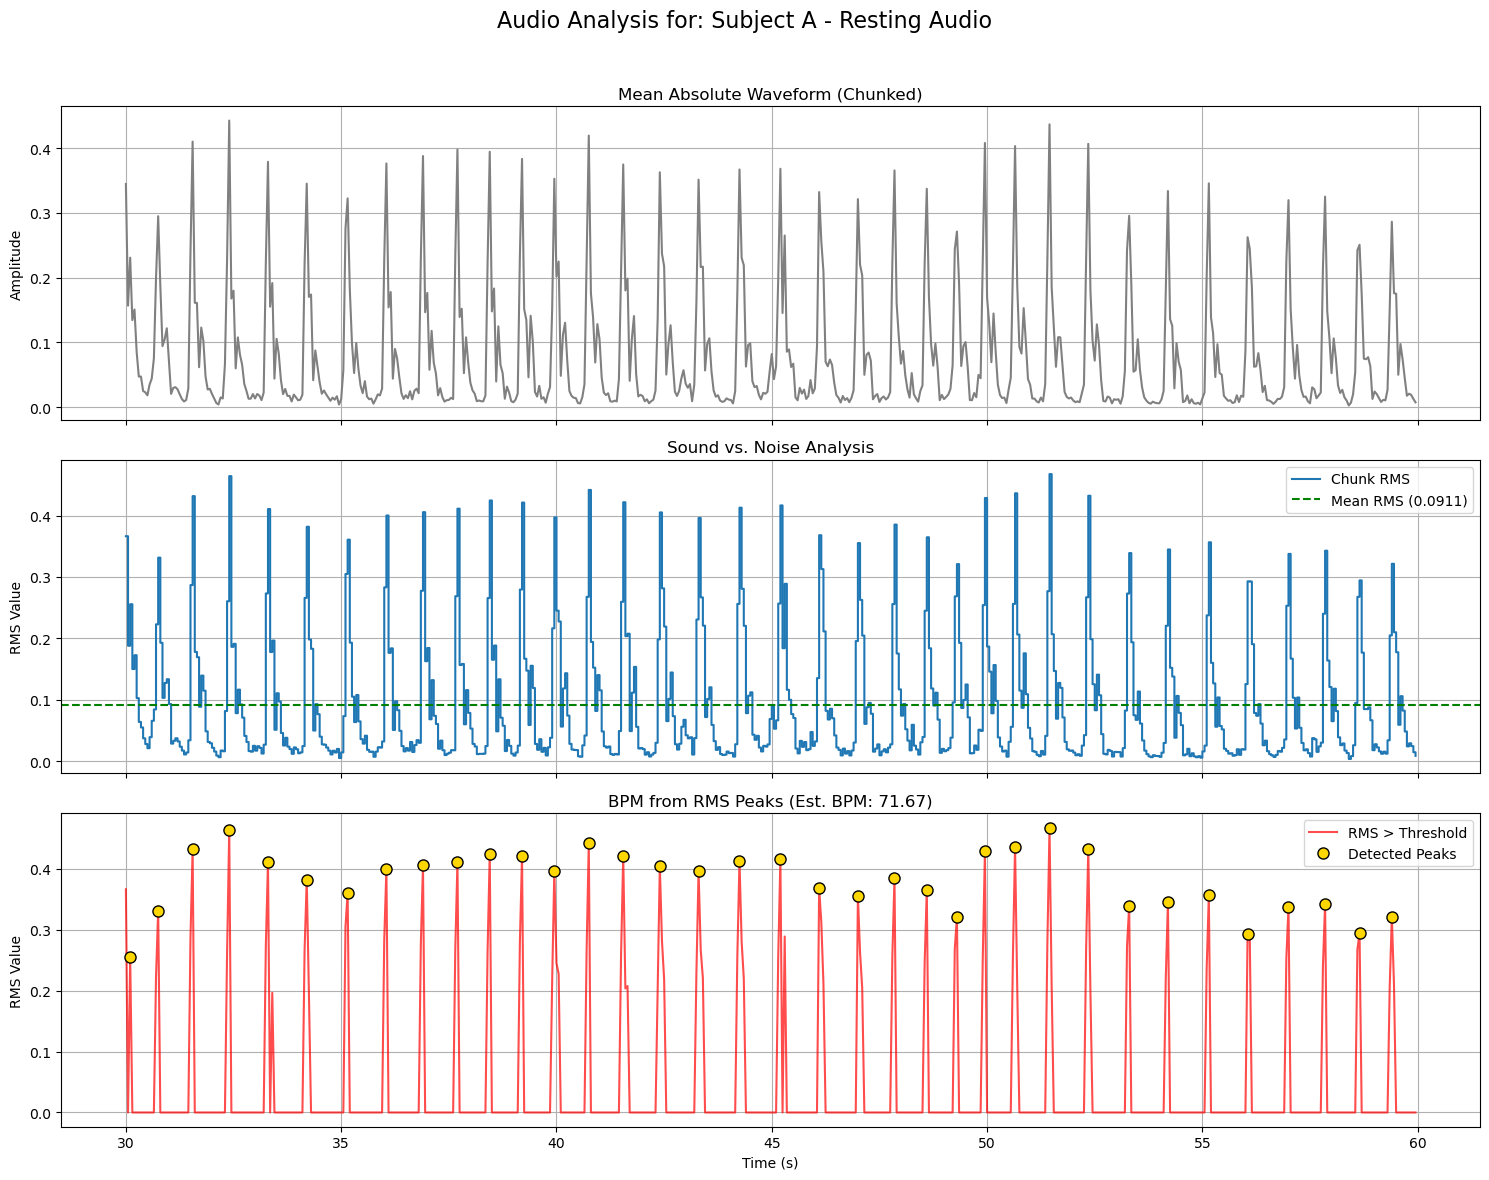


--- Audio Analysis Summary ---
Classification (Fixed SD > 0.05):      Sound
Classification (Relative SD > 0.5): Sound
BPM from RMS Peaks:                  71.67
--------------------------------

PROCESSING JOB 3/4: Subject dummy - right ear Audio
Loaded and cropped audio from 30s to 60s.


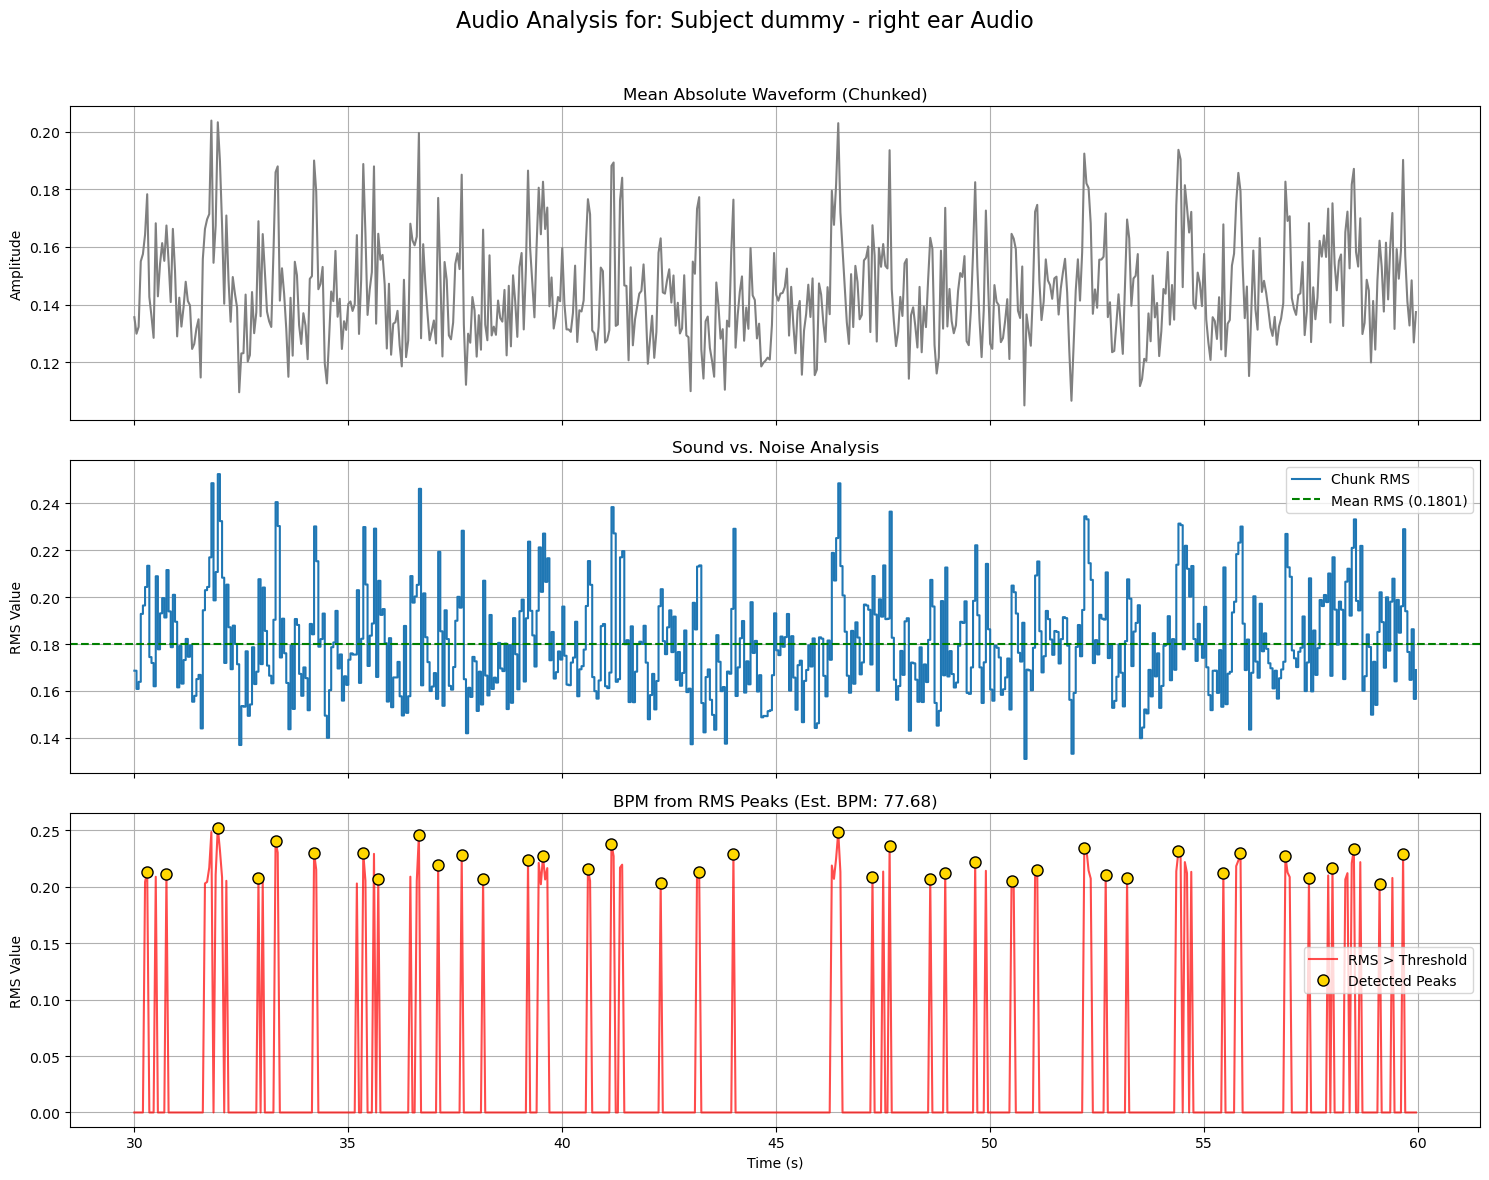


--- Audio Analysis Summary ---
Classification (Fixed SD > 0.05):      Noise
Classification (Relative SD > 0.5): Noise
BPM from RMS Peaks:                  77.68
--------------------------------

PROCESSING JOB 4/4: Subject dummy - left ear Audio
Loaded and cropped audio from 30s to 60s.


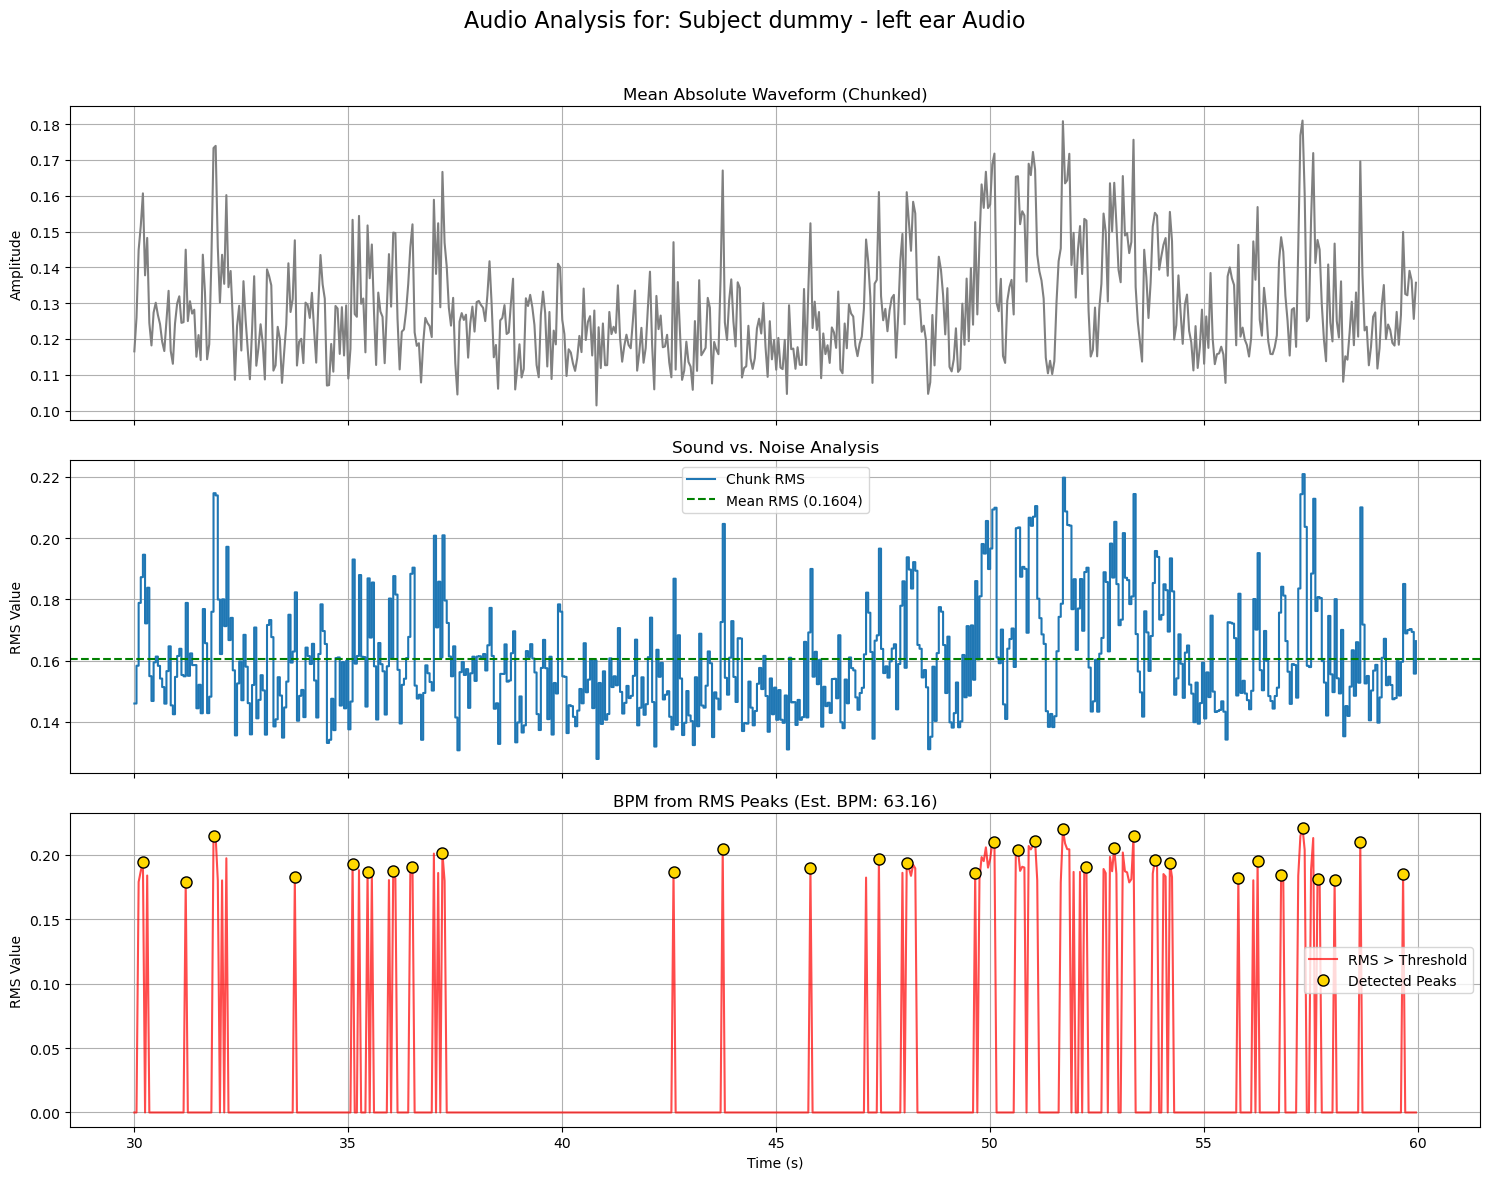


--- Audio Analysis Summary ---
Classification (Fixed SD > 0.05):      Noise
Classification (Relative SD > 0.5): Noise
BPM from RMS Peaks:                  63.16
--------------------------------

################################################################################
All audio analysis jobs have been completed.
################################################################################


In [7]:
# --- Main Audio-Only Processing Loop ---

for i, job in enumerate(audio_analysis_jobs):
    job_name = job.get('job_name', 'Unnamed Job')
    audio_file_path = job.get('audio_path')

    print("\n" + "="*80)
    print(f"PROCESSING JOB {i+1}/{len(audio_analysis_jobs)}: {job_name}")
    print("="*80)

    if not audio_file_path or not os.path.exists(audio_file_path):
        print(f"Audio Error: File not found at '{audio_file_path}'. Skipping job.")
        continue

    try:
        # --- 1. Load, Normalize, and Crop Audio ---
        sample_rate, audio = wavfile.read(audio_file_path)
        if audio.ndim > 1: audio = np.mean(audio, axis=1)
        audio = audio.astype(np.float32)
        audio /= np.max(np.abs(audio))
        
        start_s = job.get('crop_start_s')
        end_s = job.get('crop_end_s')
        start_idx = int(start_s * sample_rate)
        end_idx = int(end_s * sample_rate)
        audio_cropped = audio[start_idx:min(end_idx, len(audio))]
        
        print(f"Loaded and cropped audio from {start_s}s to {end_s}s.")
        
        # --- 2. RMS Computation ---
        chunk_duration_ms = job.get('chunk_duration_ms')
        chunk_size = int(sample_rate * (chunk_duration_ms / 1000))
        num_chunks = len(audio_cropped) // chunk_size

        if num_chunks == 0:
            print("[ERROR] Cropped audio is too short for the specified chunk duration. Skipping.")
            continue
            
        usable_waveform = np.abs(audio_cropped[:num_chunks * chunk_size])
        chunks = usable_waveform.reshape(num_chunks, chunk_size)
        rms_values = np.sqrt(np.mean(chunks**2, axis=1))

        # --- 3. Perform Analyses (Classification & BPM) ---
        
        # Sound vs. Noise Analysis
        mean_rms = np.mean(rms_values)
        std_rms = np.std(rms_values)
        relative_ratio = std_rms / mean_rms if mean_rms != 0 else 0
        classification_A = "Sound" if std_rms > job.get('rms_sd_threshold') else "Noise"
        classification_B = "Sound" if relative_ratio > job.get('rms_relative_threshold') else "Noise"
        
        # BPM from RMS Analysis
        rms_threshold = mean_rms + std_rms
        cropped_rms = np.where(rms_values >= rms_threshold, rms_values, 0)
        peaks, _ = find_peaks(cropped_rms, distance=job.get('bpm_peak_distance'))
        
        bpm = 0
        if len(peaks) > 1:
            avg_interval_s = np.mean(np.diff(peaks)) * (chunk_duration_ms / 1000)
            bpm = 60 / avg_interval_s

        # --- 4. Plotting ---
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
        fig.suptitle(f"Audio Analysis for: {job_name}", fontsize=16)
        
        time_axis = (np.arange(num_chunks) * chunk_size + start_idx) / sample_rate
        
        ax1.plot(time_axis, usable_waveform.reshape(-1, chunk_size).mean(axis=1), color='gray')
        ax1.set_title("Mean Absolute Waveform (Chunked)")
        ax1.set_ylabel("Amplitude")
        ax1.grid(True)
        
        ax2.step(time_axis, rms_values, where='post', label='Chunk RMS')
        ax2.axhline(mean_rms, color='g', ls='--', label=f'Mean RMS ({mean_rms:.4f})')
        ax2.set_title("Sound vs. Noise Analysis")
        ax2.set_ylabel("RMS Value")
        ax2.legend()
        ax2.grid(True)

        ax3.plot(time_axis, cropped_rms, 'r-', alpha=0.7, label=f'RMS > Threshold')
        ax3.plot(time_axis[peaks], cropped_rms[peaks], 'o', color='gold', markersize=8, markeredgecolor='black', label='Detected Peaks')
        ax3.set_title(f"BPM from RMS Peaks (Est. BPM: {bpm:.2f})")
        ax3.set_xlabel("Time (s)")
        ax3.set_ylabel("RMS Value")
        ax3.legend()
        ax3.grid(True)
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

        # --- 5. Final Summary ---
        print("\n--- Audio Analysis Summary ---")
        print(f"Classification (Fixed SD > {job.get('rms_sd_threshold')}):      {classification_A}")
        print(f"Classification (Relative SD > {job.get('rms_relative_threshold')}): {classification_B}")
        print(f"BPM from RMS Peaks:                  {bpm:.2f}")
        print("--------------------------------")

    except Exception as e:
        print(f"An unexpected error occurred during analysis for {job_name}: {e}")

print("\n" + "#"*80)
print("All audio analysis jobs have been completed.")
print("#"*80)